## Settings

In [3]:
import io
from typing import Any, Dict, List, OrderedDict, Union
import os
from os.path import join as osj
import cv2
import decord
import matplotlib
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib.collections import LineCollection
import random
import pandas as pd
from workoutdetector.datasets import FrameDataset, build_test_transform, RepcountHelper
from workoutdetector.utils.visualize import plot_all, plt_params, plot_per_action, parse_json
from matplotlib import font_manager
import json
from workoutdetector.time_series import reps_to_label


matplotlib.RcParams.update(plt_params())
font_path = '/mnt/c/Users/Me/AppData/Local/Microsoft/Windows/Fonts/Cairo-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
font_manager.findSystemFonts(fontext='otf')
fe = font_manager.FontEntry(fname=font_path, name='Cairo')
font_manager.fontManager.ttflist.insert(0, fe) 
matplotlib.rcParams.update(plt_params())
matplotlib.rcParams['font.family'] = 'Cairo'

CLASSES = ['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']

COLORS = list(plt.get_cmap('tab20').colors)

params = {
    'figure.dpi': 300,
    'figure.figsize': (8, 5),
    'figure.autolayout': True,
    'lines.linewidth': 1,
    'axes.prop_cycle': plt.cycler('color', COLORS),
    'font.size': 10,
    'font.family': 'Cairo',
}


In [4]:
data_root = os.path.expanduser("~/data/RepCount")
anno_path = osj(data_root, "annotation.csv")
helper = RepcountHelper(data_root, anno_path)
CLASSES = helper.classes
print(CLASSES)
data = list(helper.get_rep_data(['train', 'val', 'test'], ['all']).values())

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']


In [5]:
json_dir = os.path.expanduser('~/projects/WorkoutDetector/out/acc_0.841_epoch_26_20220711-191616_1x1')
json_files = os.listdir(json_dir)
template  = '{}.stride_1_step_1.json'
print(len(json_files))
print(json_files[0])
print(json.load(open(osj(json_dir, json_files[0]))).keys())

762
stu7_51.mp4.stride_1_step_1.json
dict_keys(['video_name', 'model', 'stride', 'step', 'length', 'fps', 'input_shape', 'checkpoint', 'total_frames', 'ground_truth', 'action', 'scores'])


video: stu8_41.mp4
class: push_up
count: 22
reps: [49, 92, 92, 128, 128, 163, 163, 192, 192, 220, 220, 249, 249, 283, 283, 313, 313, 345, 345, 375, 376, 404, 404, 433, 433, 463, 463, 492, 492, 517, 517, 547, 547, 574, 574, 602, 602, 629, 629, 660, 808, 911, 911, 1091]
fps: 30.0


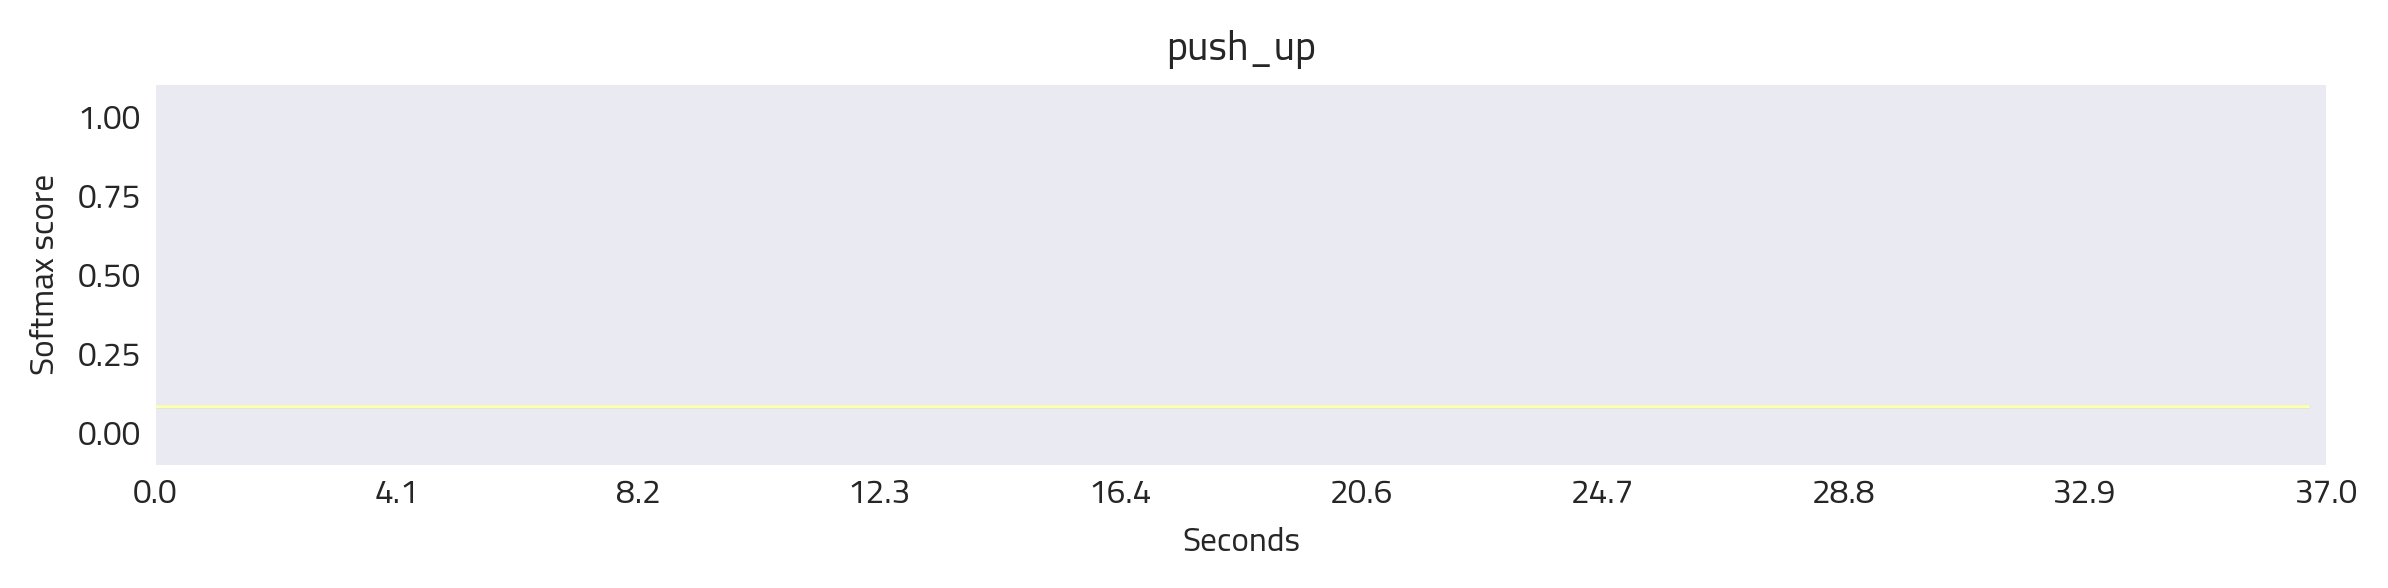

In [6]:
item = random.choice(data)
print(item)
js = json.load(open(osj(json_dir, template.format(item.video_name))))

# plot_all(js['ground_truth'], js, softmax=True, stride=1)
plot_per_action(js, softmax=True, action_only=True)

## Hidden Markov Model

- Input: a sequence of probabilities of shape (seq_len, 12)
- Output: a integer state

In [20]:
from hmmlearn import hmm
from workoutdetector.datasets import FeatureDataset
from workoutdetector.utils import pred_to_count
from torch.utils.data import DataLoader

In [380]:
def train(action):
    feat_ds = FeatureDataset(json_dir, anno_path, 'train',action=action, window=1, stride=1)
    print(action, feat_ds.x.shape, 'num y', np.unique(feat_ds.y))
    # softmax_x = F.softmax(torch.from_numpy(feat_ds.x), dim=1).numpy()
    transmat, pi, means, cov = feat_ds.hmm_stats(feat_ds.x, feat_ds.y)
    # print(transmat, pi, means, cov)
    n_states = len(np.unique(feat_ds.y))
    model = hmm.GaussianHMM(n_components=n_states, n_iter=300, covariance_type='diag')
    model.transmat_ = transmat
    model.startprob_ = pi.T
    model.means_ = means
    model.covars_ = cov
    softmax_x = F.softmax(torch.from_numpy(feat_ds.x.squeeze(1)), dim=1)
    # model.fit(softmax_x.numpy())
    return model


def hmm_infer(model, x, gt_reps, class_idx):
    gt_labels = reps_to_label(gt_reps, len(x), class_idx=class_idx) # set to 0 for 3 states
    y = model.predict(x)
    acc = (y == gt_labels[:len(y)]).sum() / len(gt_labels)
    gt_count = len(gt_reps) // 2
    count, reps = pred_to_count(y-1, stride=1, step=1) # minus 1 because no-class is 0
    diff = abs(count - gt_count)
    obo = 1 if (diff <= 1) else 0
    return obo, diff, acc,  reps

action = 'all'
model = train(action)

all (463086, 1, 12) num y [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


### Predict

(292, 12) [0 0 0 0 0 0 0 0 0 0]
startprob_ (13,)
count 2 name train3898.mp4 squat
pred count 7
obo=0 err=5 acc=0.3082191780821918


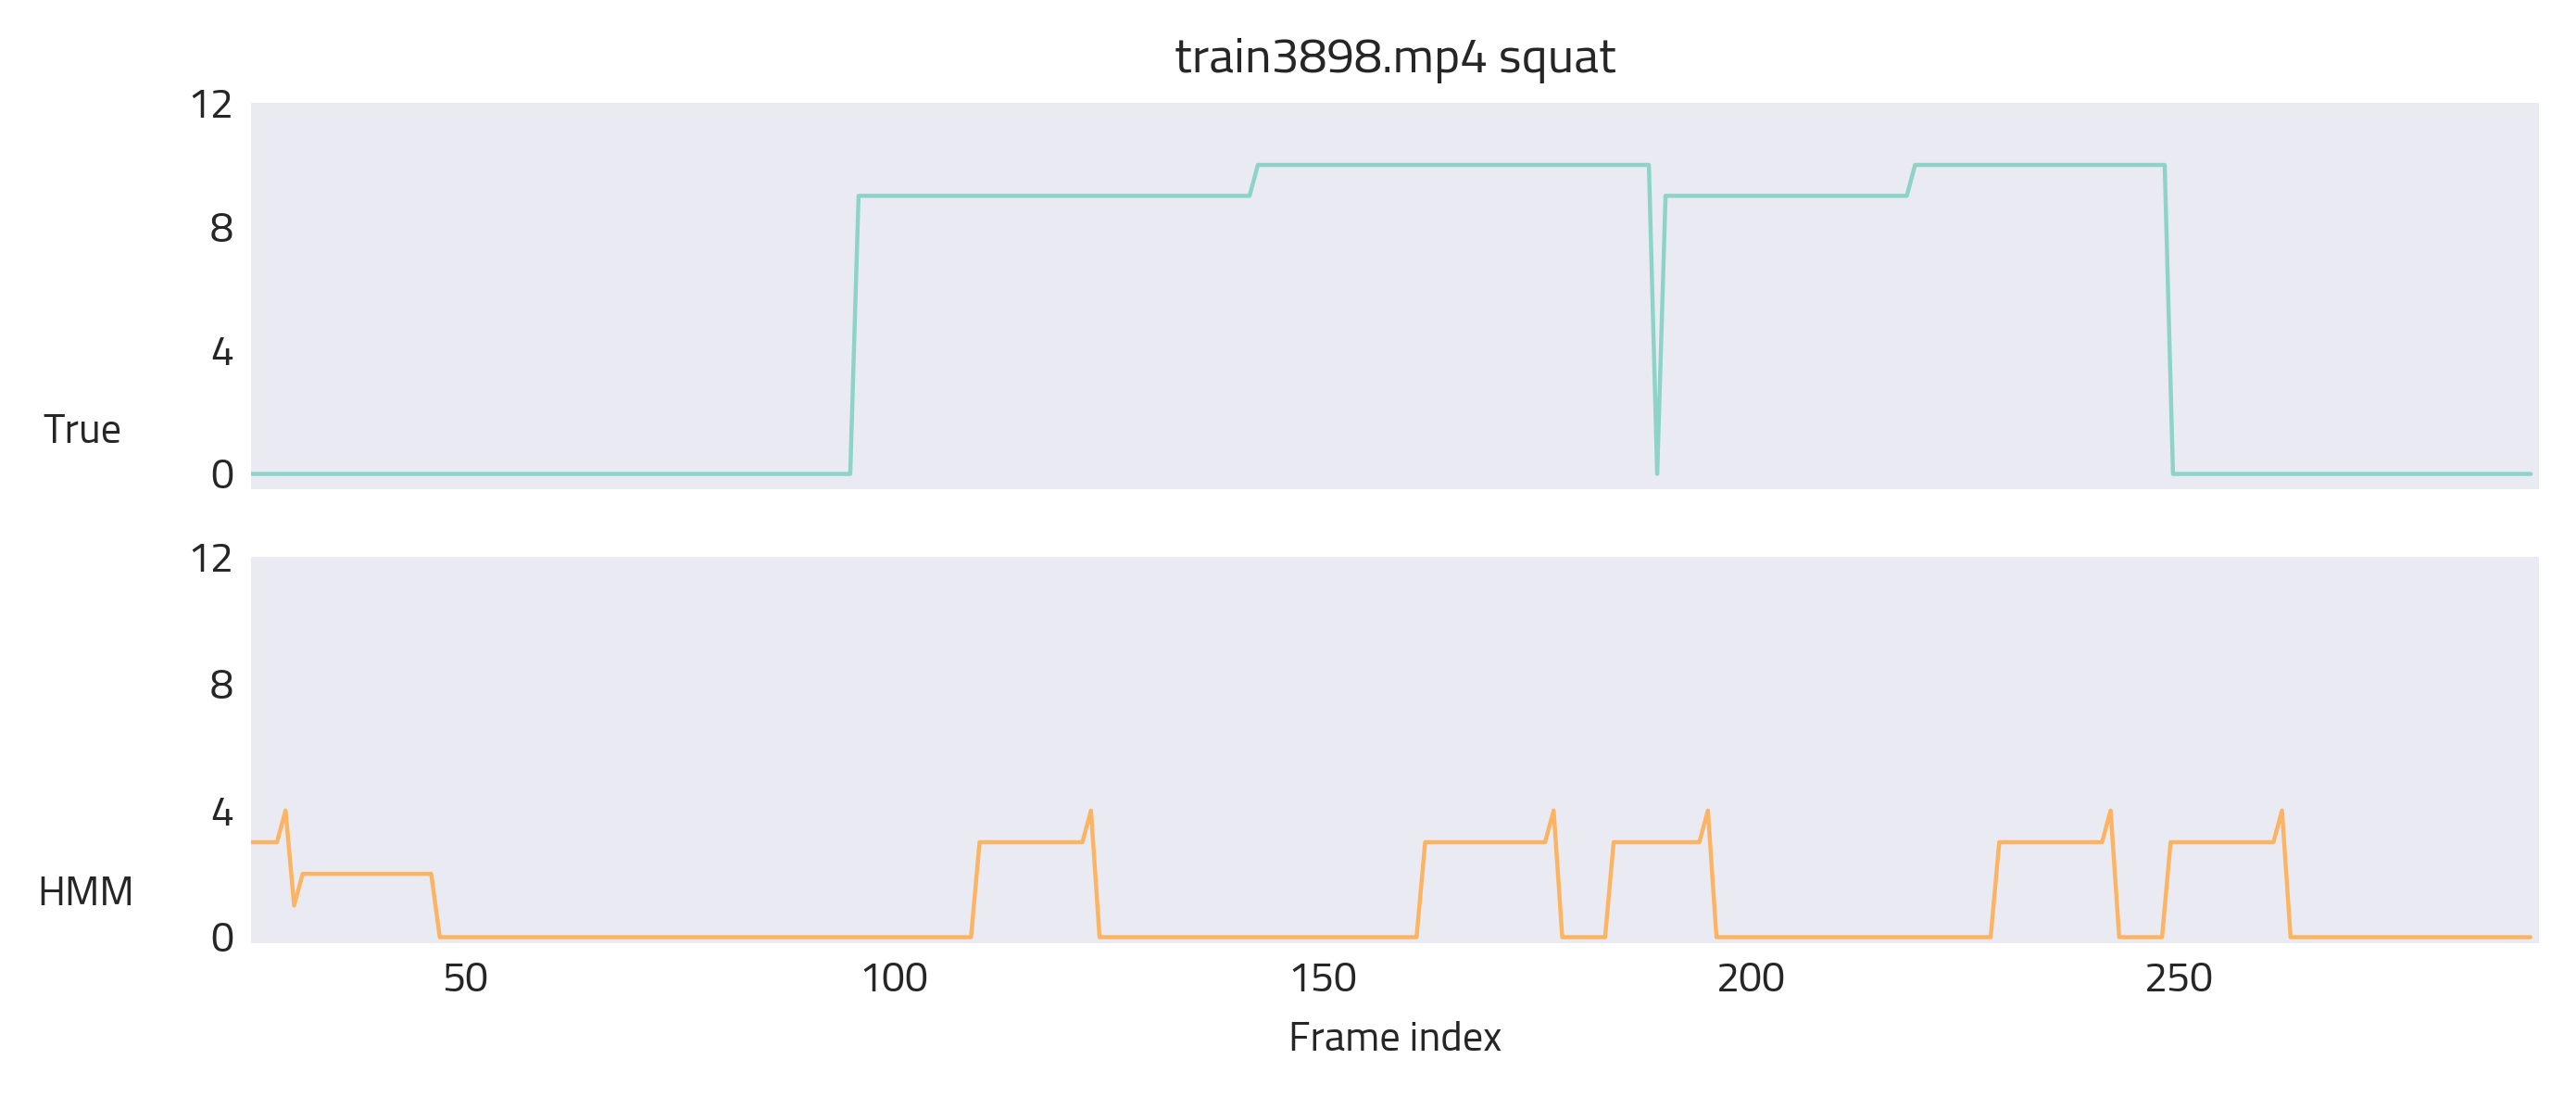

In [387]:
val_data = list(helper.get_rep_data(['val'], [action]).values())
item = random.choice(val_data)

val_x = []
js = json.load(open(osj(json_dir, template.format(item.video_name))))
for i,v in js['scores'].items():
    val_x.append(np.array(list(v.values())))
val_x = np.array(val_x)
class_idx = CLASSES.index(item.class_)
val_y = np.array(reps_to_label(item.reps, item.total_frames, class_idx=class_idx))
print(val_x.shape, val_y[:10])
print('startprob_', model.startprob_.shape)
pred = model.predict(val_x)
print('count', len(js['ground_truth'])//2, 'name', item.video_name, item.class_)

obo, err, acc, reps = hmm_infer(model, val_x, item.reps, 0)
print('pred count', len(reps) // 2)
print(f'obo={obo} err={err} acc={acc}')

fig, ax = plt.subplots(2, 1, figsize=(7,3), dpi=400)
ax[0].plot(val_y, 'C0', label='true')
ax[1].plot(pred, 'C5', label='HMM')
ax[0].set_yticks(range(0, 13, 4))
ax[0].set_xticks([])
ax[1].set_yticks(range(0, 13, 4))
ax[0].set_xlim(len(val_y)//12, len(val_y))
ax[1].set_xlim(len(val_y)//12, len(pred))
ax[0].text(0, 1 ,'True')
ax[1].text(0, 1 ,'HMM')
ax[0].set_title(f'{item.video_name} {item.class_}')
ax[1].set_xlabel('Frame index')
plt.tight_layout()
plt.show()

### Eval

In [373]:
def eval_subset(model, split, action):
    test_data = list(helper.get_rep_data([split], [action]).values())
    total_obo, total_err, total_acc, gt_total_count = 0, 0, 0, 0
    for item in test_data:
        test_x = []
        js = json.load(open(osj(json_dir, template.format(item.video_name))))
        for i,v in js['scores'].items():
            test_x.append(np.array(list(v.values())))
        test_x = np.array(test_x)

        pred = model.predict(test_x)
        obo, err, acc, reps = hmm_infer(model, test_x, item.reps, CLASSES.index(item.class_))
        total_obo += obo
        total_err += err
        total_acc += acc
        gt_total_count += len(item.reps) // 2

    err_rate = total_err / len(test_data)
    acc_rate = total_acc / len(test_data)
    return dict(split=split, action=action, 
        OBO=total_obo, num_videos=len(test_data),
        MAE=err_rate, avg_count=gt_total_count/len(test_data), hmm_acc=acc_rate)

result = []
model_all = train('all')
for action in CLASSES:
    # model = train(action)
    for split in ['train', 'val', 'test']:
        result.append(eval_subset(model_all, split, action))

df = pd.DataFrame(result)
df.to_csv('hmm_result.csv')
print(df.to_latex(index=False))

all (463086, 1, 12) num y [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
\begin{tabular}{llrrrrr}
\toprule
split &      action &  OBO &  num\_videos &       MAE &  avg\_count &  hmm\_acc \\
\midrule
train &       situp &   18 &          94 & 11.553191 &  12.553191 & 0.354606 \\
  val &       situp &    1 &          18 & 14.666667 &  14.888889 & 0.405333 \\
 test &       situp &    1 &          20 & 14.100000 &  13.500000 & 0.422420 \\
train &     push\_up &    9 &          87 & 16.413793 &  19.402299 & 0.428646 \\
  val &     push\_up &    2 &          18 & 14.111111 &  13.055556 & 0.406846 \\
 test &     push\_up &    1 &          16 & 16.937500 &  18.937500 & 0.376581 \\
train &     pull\_up &   21 &          94 &  8.648936 &  10.968085 & 0.442854 \\
  val &     pull\_up &    2 &          14 & 14.214286 &  11.571429 & 0.477709 \\
 test &     pull\_up &    6 &          19 &  8.157895 &  11.421053 & 0.500090 \\
train &   jump\_jack &   16 &          76 & 11.855263 &  22.815789 & 0.416510 \\


## LSTM Visualization

In [10]:
@matplotlib.rc_context(params)
def plot_pred(result: List[int],
              gt: List[int],
              orig_reps: List[int],
              total_frames: int,
              fps: float,
              title: str,
              step: int = 8,
              show: bool = True,
              save_path: str = None) -> None:
    video_len = total_frames / fps
    max_num_ticks = 10
    plt.figure(figsize=(8, 2))
    plt.xlabel('Second', fontsize=10)
    plt.yticks([])
    plt.ylim(0, 1)
    offset = total_frames // 7
    plt.xlim(-offset * 1.1, total_frames + 5)
    h = 0.2
    plt.xticks(np.linspace(0, total_frames, max_num_ticks),
               np.round(np.linspace(0.0, video_len, max_num_ticks), 2), fontsize=10)
    # background
    rect = plt.Rectangle((0, h), total_frames, 0.6, color='w')
    plt.gca().add_patch(rect)
    for i in range(0, len(gt), 2):
        rect = plt.Rectangle((gt[i], 0.6), (gt[i + 1] - gt[i]), h, color='C1')
        plt.gca().add_patch(rect)
    plt.vlines(gt, color='C0', linewidth=2, ymin=0.6, ymax=0.8)
    for j in range(0, len(result), 2):
        rect = plt.Rectangle((result[j], 0.4), (result[j + 1] - result[j]),
                             h - 0.01,
                             color='C2')
        plt.gca().add_patch(rect)
    for i in range(0, len(orig_reps), 2):
        rect = plt.Rectangle((orig_reps[i], 0.2), (orig_reps[i + 1] - orig_reps[i]),
                             h - 0.01,
                             color='C5')
        plt.gca().add_patch(rect)
    plt.title(title)
    plt.text(-offset, 0.65, 'Ground Truth', color='C0', fontsize=9)
    plt.text(-offset, 0.45, 'LSTM Prediction', color='C2', fontsize=9)
    plt.text(-offset, 0.25, 'Baseline', color='C4', fontsize=9)
    if show:
        plt.show()
    if save_path is not None:
        plt.savefig(save_path)
    plt.close()

In [11]:
from workoutdetector.datasets import RepcountHelper
from workoutdetector.utils.eval import load_json, infer
from workoutdetector.utils import pred_to_count

data_root = os.path.expanduser("~/data/RepCount")
json_dir = '../out/acc_0.841_epoch_26_20220711-191616_1x1'
metrics_df = pd.read_csv('../exp/time_series/test_metrics_1.csv', index_col=0)
print(metrics_df.head(1))
anno_path = os.path.expanduser("~/data/RepCount/annotation.csv")
helper = RepcountHelper(data_root, anno_path)
CLASSES = helper.classes
print(CLASSES)
data = helper.get_rep_data(['train', 'val', 'test'], ['all'])

                   action  split       acc  pred_count  gt_count  \
name                                                               
train951.mp4  front_raise  train  0.751295           2         4   

                       pred_reps  gt_reps  
name                                       
train951.mp4  [41, 74, 102, 132]      NaN  
['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']


train2542.mp4
gt 1 LSTM 2 Baseline 2


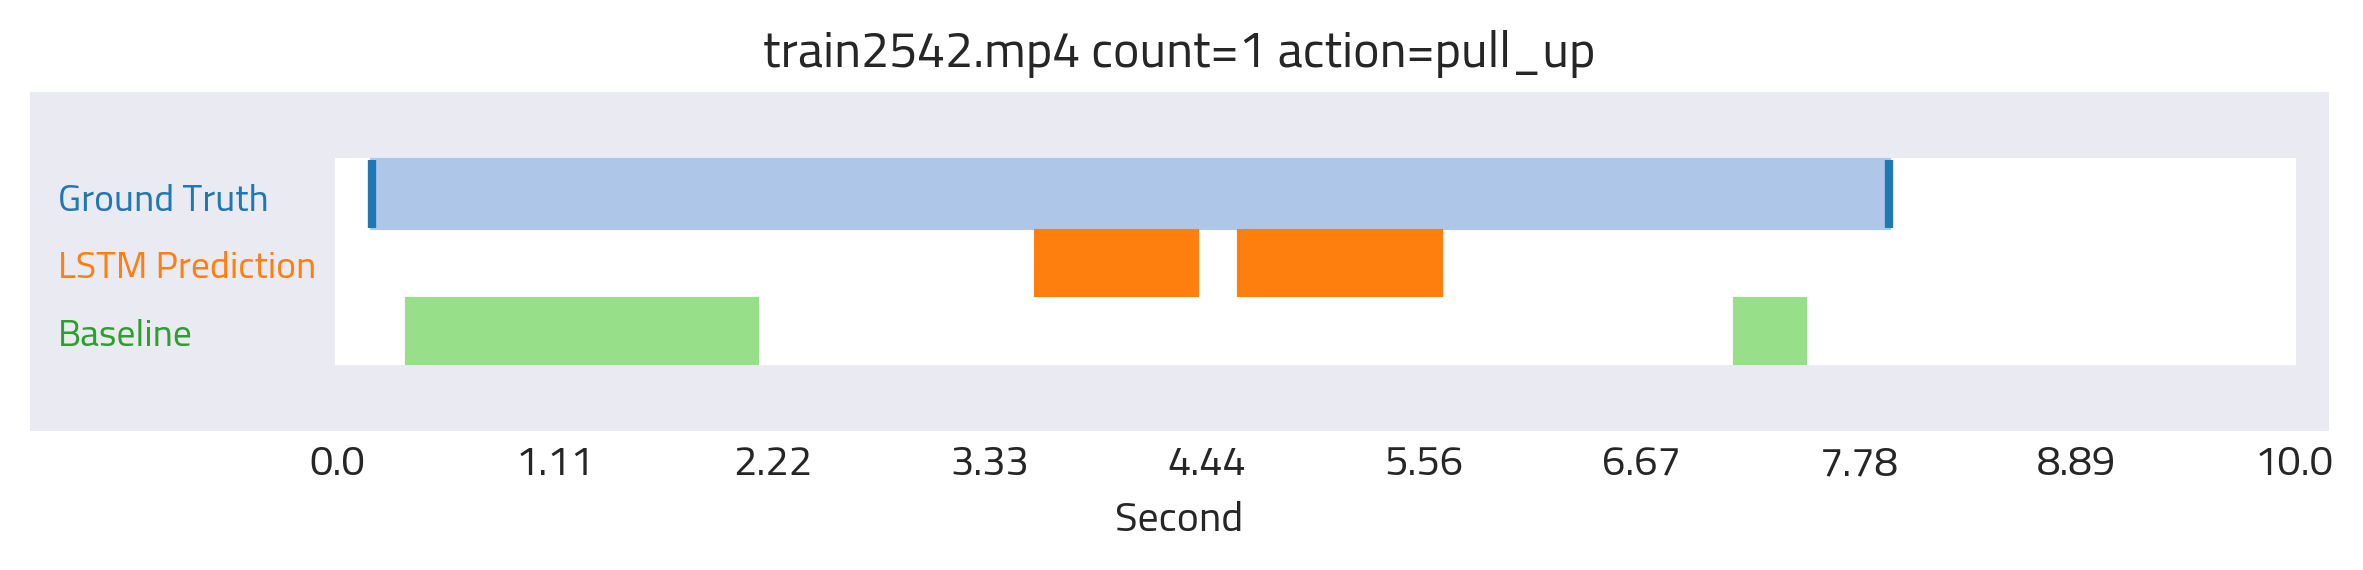

In [12]:
item = metrics_df.loc[random.choice(metrics_df[metrics_df['split'] != 'train'].index)]
json_file = f'{json_dir}/{item.name}.stride_1_step_1.json'
score, _ = load_json(json_file, softmax=True)
base_count, base_reps = pred_to_count(infer(score, 0.6, window=10), stride=1*10, step=1)
# print(orig_reps)
pred_rep = list(map(int, item.pred_reps[1:-1].split(','))) if len(item.pred_reps) > 2 else []
# print(pred_rep)
print(item.name)
print('gt', item.gt_count, 'LSTM', len(pred_rep)//2, 'Baseline', base_count)
x = data[item.name]
plot_pred(pred_rep, x.reps, base_reps, x.total_frames, x.fps, 
    title=f"{x.video_name} count={x.count} action={x.class_}", step=1)

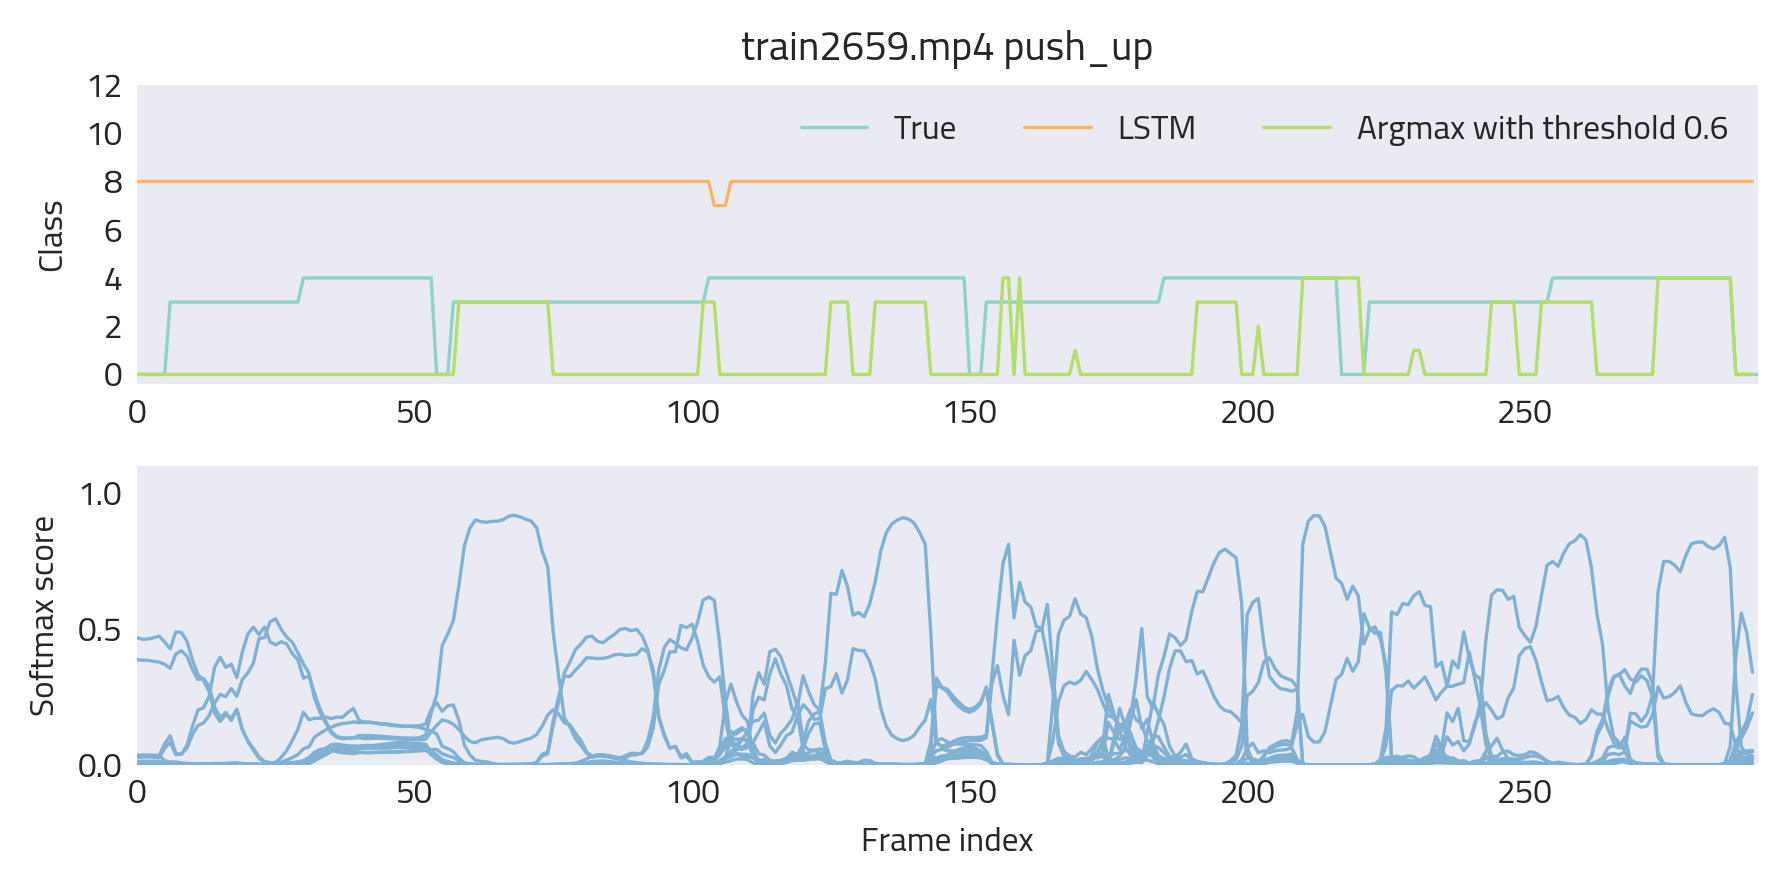

In [156]:
lstm_data = np.load('../exp/time_series/acc_0.598_epoch_000-v1.ckpt.npy', allow_pickle=True)
lstm_npy = lstm_data[random.choice(range(len(lstm_data)))]
lstm_item = data[lstm_npy['name']]
gt_reps = lstm_item.reps
true_y = reps_to_label(gt_reps, total=lstm_item.total_frames, class_idx=CLASSES.index(lstm_item.class_))
lstm_y = lstm_npy['pred']
lstm_js = json.load(open(osj(json_dir, template.format(lstm_item.video_name))))
yarr = parse_json(list(lstm_js['scores'].values()), True)
baseline = yarr.argmax(axis=1) + 1 # +1 because 0 is background
baseline = [b  if yarr[idx].max() >= 0.6 else 0 for idx, b in enumerate(baseline)]

fig, ax = plt.subplots(2, 1, figsize=(6, 3))
ax[0].plot(true_y, 'C0', label='True')
ax[0].plot(lstm_y, 'C5', label='LSTM')
ax[0].plot(baseline, 'C6', label='Argmax with threshold 0.6')
ax[0].legend(ncol=3, fontsize=8)
ax[0].set_yticks(range(0, 13, 2))
ax[0].set_xlim(0, len(lstm_y))
ax[0].set_title(f'{lstm_item.video_name} {lstm_item.class_}')
ax[0].set_ylabel('Class')
ax[1].plot(yarr, 'C4', label='Input')
ax[1].set_xlabel('Frame index')
ax[1].set_ylim(0, 1.1)
ax[1].set_xlim(0, len(yarr))
ax[1].set_ylabel('Softmax score')
plt.tight_layout()
plt.show()

In [346]:
def save_all_lstm_plot(csv_path: str, out_dir: str) -> None:
    os.makedirs(out_dir, exist_ok=True)
    metrics_df = pd.read_csv(csv_path)
    val_test_df = metrics_df[metrics_df['split'] != 'train']
    print(val_test_df.columns)
    for item in val_test_df.itertuples():
        json_file = f'{json_dir}/{item.name}.stride_1_step_1.json'
        score, _ = load_json(json_file, softmax=True)
        base_count, base_reps = pred_to_count(infer(score, 0.6, window=10), stride=1*10, step=1)
        # print(orig_reps)
        pred_rep = list(map(int, item.pred_reps[1:-1].split(','))) if len(item.pred_reps) > 2 else []
        # print(pred_rep)
        # print(item.name)
        # print('gt', item.gt_count, 'LSTM', len(pred_rep)//2, 'Baseline', base_count)
        x = data[item.name]
        plot_pred(pred_rep, x.reps, base_reps, x.total_frames, x.fps, 
            title=f"{x.video_name} count={x.count} action={x.class_}", step=1, show=False,
            save_path=f'{out_dir}/{item.name}.png')

# save_all_lstm_plot('../exp/time_series/test_metrics_1.csv', '../out/time_series/lstm_plot')

Index(['name', 'action', 'split', 'acc', 'pred_count', 'gt_count', 'pred_reps',
       'gt_reps'],
      dtype='object')
